In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import elephant
import quantities as pq
import neo
import sys
from scipy.stats import ks_2samp, wilcoxon, mannwhitneyu
plt.rcParams['figure.figsize'] = (14, 10)
import scipy.stats as stats
import itertools
import random

# Kullback-Leibler divergence

We will look more into the Kullback-Leibler divergence. It is a measure of how distant two distributions are from eachother. We will start by looking at the KL divergence for discrete distributions. That is, we estimate probability density functions for the two distributions being compared. The code for calculating this is given below:

In [2]:
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/len(data)
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

def kl_divergences(cv_lists, n_bins=10):
    """
    Calculate the KL divergence for each combination of pairs of simulations from the same model.
    Possible to give number of bins inn this function.
    """
    cv_lists = cv_lists.values.tolist()
    divs = []
    for i in range(0,10):
        for j in range(0,i):
            kl = compute_kl_divergence(cv_lists[i],cv_lists[j], n_bins=n_bins)
            divs.append(kl)
    return divs

One of the questions/challenges regarding this descrete version is the number of bins. Lets try this on mock data, and see how the values changes as the number of bins changes. The number of bins the data sample is split into.Samples of size 10 000, so could use a large number of bins.

In [3]:
# create 10 normal distributions with 10 000 numbers, mean 0 and standard deviation 1
x = np.random.normal(0, 1, size=(10,10000))

def kl_divergences_x(cv_lists, n_bins=10):
    """
    Calculate the KL divergence for each combination of pairs of simulations from the same model.
    Possible to give number of bins inn this function.
    """
    divs = []
    for i in range(0,10):
        for j in range(0,i):
            kl = compute_kl_divergence(cv_lists[i],cv_lists[j], n_bins=n_bins)
            divs.append(kl)
    return divs

In [4]:
kl_10 = kl_divergences_x(x,n_bins=10)
kl_20 = kl_divergences_x(x,n_bins=20)
kl_30 = kl_divergences_x(x,n_bins=30)
kl_40 = kl_divergences_x(x,n_bins=40)
kl_43 = kl_divergences_x(x,n_bins=43) # best choice according to RIce 1944
kl_50 = kl_divergences_x(x,n_bins=50)
kl_70 = kl_divergences_x(x,n_bins=70)
kl_80 = kl_divergences_x(x,n_bins=80)
kl_100 = kl_divergences_x(x,n_bins=100)
kl_1000 = kl_divergences_x(x,n_bins=1000)

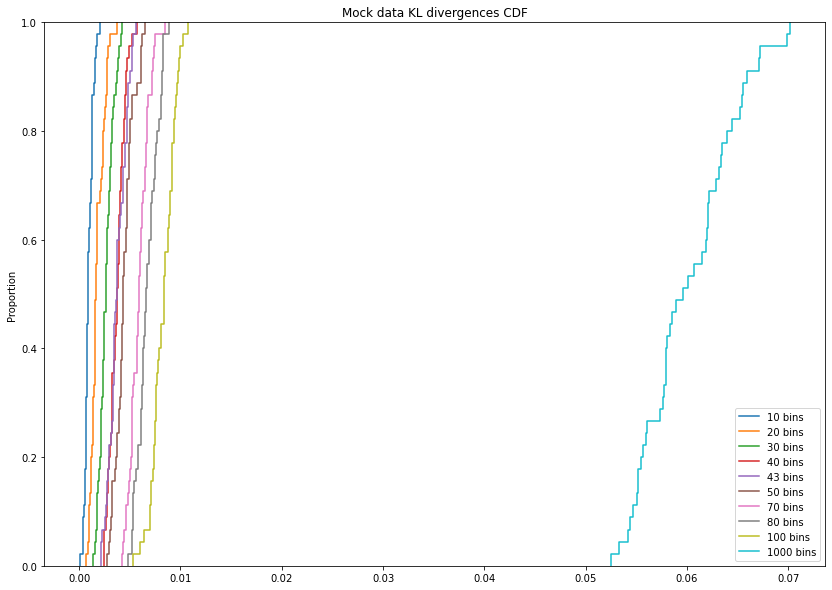

In [5]:
_, axs = plt.subplots(1)
sns.ecdfplot(kl_10,ax=axs, label='10 bins')
sns.ecdfplot(kl_20,ax=axs, label='20 bins')
sns.ecdfplot(kl_30,ax=axs, label='30 bins')
sns.ecdfplot(kl_40,ax=axs, label='40 bins')
sns.ecdfplot(kl_43,ax=axs, label='43 bins')
sns.ecdfplot(kl_50,ax=axs, label='50 bins')
sns.ecdfplot(kl_70,ax=axs, label='70 bins')
sns.ecdfplot(kl_80,ax=axs, label='80 bins')
sns.ecdfplot(kl_100,ax=axs, label='100 bins')
sns.ecdfplot(kl_1000,ax=axs, label='1000 bins')
plt.title('Mock data KL divergences CDF')
plt.legend();

The cumulative function moves as a higher number of bins is used. But most of the curves show that the kl divergence for all possible pairs is under 0.014. Could check for more number of bins to decide on a value we view as a uppe rlimit for samples to be qualified as equal. See that for 1000 bins the kl divergences is under 0.08. Maybe try to plot for the brunel model with rounded spike times and delays [1.0,2.0].

In [21]:
p =pd.read_csv('C:\\Users\\Nida\\Documents\\NMBU\\master\\spike_data\\brunel_10s\\resolution_1_8\\brunel_rounding_1_2\\brunel_rounding_True_delay_1.0_2.0_seed_1_spikes_exc-12502-0.dat',sep='\t',skiprows=2)

(0.0, 100.0)

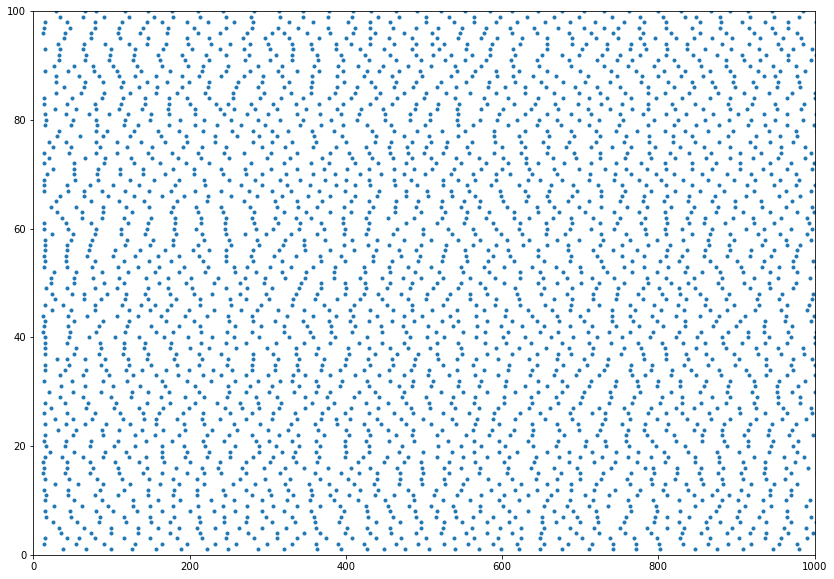

In [26]:
plt.plot(p.time_ms,p.sender,'.')
plt.xlim(0,1000)
plt.ylim(0,100)

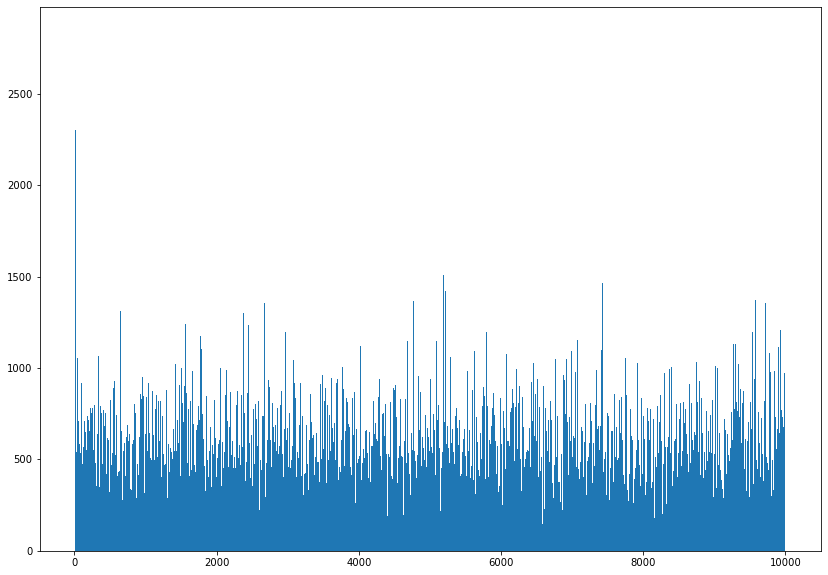

In [30]:
plt.hist(p.time_ms,bins=5000);

In [25]:
p.describe()

,sender,time_ms
count,3.198904e+06,3.198904e+06
mean,4.999866e+03,5.003337e+03
std,2.886488e+03,2.885281e+03
min,1.000000e+00,1.050000e+01
25%,2.500000e+03,2.505500e+03
50%,5.000000e+03,5.007250e+03
75%,7.499000e+03,7.501625e+03
max,1.000000e+04,1.000000e+04


In [6]:
cv_path = 'C:\\Users\\Nida\\Documents\\NMBU\\master\\spike_data\\CV_distributions\\resolution_1_8'
round_1_2_exc = pd.read_csv(r'{}/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
round_1_2_inh = pd.read_csv(r'{}/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)
exact_1_2_exc = pd.read_csv(r'{}/brunel_exact_1_2_exc_cv.csv'.format(cv_path),index_col=0)
exact_1_2_inh = pd.read_csv(r'{}/brunel_exact_1_2_inh_cv.csv'.format(cv_path),index_col=0)
round_equal_exc = pd.read_csv(r'{}/brunel_round_equal_exc_cv.csv'.format(cv_path),index_col=0)
round_equal_inh = pd.read_csv(r'{}/brunel_round_equal_inh_cv.csv'.format(cv_path),index_col=0)
exact_equal_exc = pd.read_csv(r'{}/brunel_exact_equal_exc_cv.csv'.format(cv_path),index_col=0)
exact_equal_inh = pd.read_csv(r'{}/brunel_exact_equal_inh_cv.csv'.format(cv_path),index_col=0)
continuous_exc = pd.read_csv(r'{}/brunel_continuous_exc_cv.csv'.format(cv_path),index_col=0)
continuous_inh = pd.read_csv(r'{}/brunel_continuous_inh_cv.csv'.format(cv_path),index_col=0)

<AxesSubplot:xlabel='1', ylabel='Proportion'>

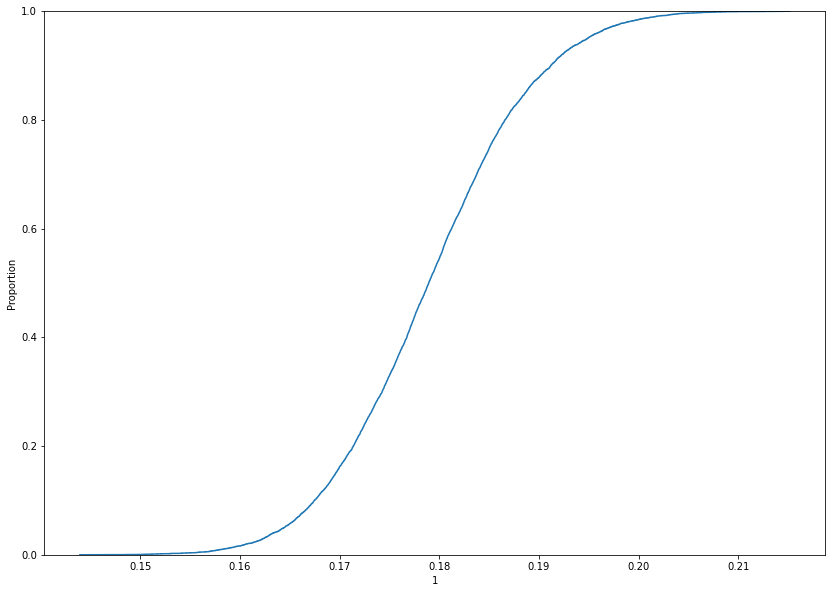

In [7]:
sns.ecdfplot(continuous_exc.iloc[1])

In [8]:
exc_10 = kl_divergences(round_1_2_exc,n_bins=10)
exc_20 = kl_divergences(round_1_2_exc,n_bins=20)
exc_30 = kl_divergences(round_1_2_exc,n_bins=30)
exc_40 = kl_divergences(round_1_2_exc,n_bins=40)
exc_43 = kl_divergences(round_1_2_exc,n_bins=43) #rice 1944
exc_50 = kl_divergences(round_1_2_exc,n_bins=50)
exc_70 = kl_divergences(round_1_2_exc,n_bins=70)
exc_80 = kl_divergences(round_1_2_exc,n_bins=80)
exc_100 = kl_divergences(round_1_2_exc,n_bins=100)

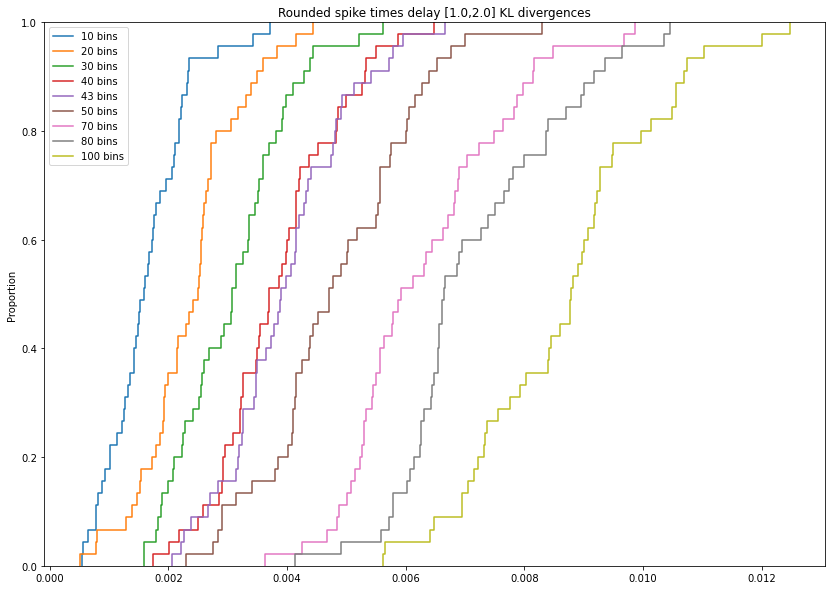

In [9]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(exc_10,ax=axs, label='10 bins')
sns.ecdfplot(exc_20,ax=axs, label='20 bins')
sns.ecdfplot(exc_30,ax=axs, label='30 bins')
sns.ecdfplot(exc_40,ax=axs, label='40 bins')
sns.ecdfplot(exc_43,ax=axs, label='43 bins')
sns.ecdfplot(exc_50,ax=axs, label='50 bins')
sns.ecdfplot(exc_70,ax=axs, label='70 bins')
sns.ecdfplot(exc_80,ax=axs, label='80 bins')
sns.ecdfplot(exc_100,ax=axs, label='100 bins')
plt.title('Rounded spike times delay [1.0,2.0] KL divergences')
plt.legend();

Looks very similar to the mock data example. THe KL divergences are all under 0.014. Lets try to plot for a case where we compare two different models.

In [10]:
def kl_div_two_models(value_list_1, value_list_2,n_bins=10):
    """
    Calculate KL divergence for each possible pair of simulations from two models.
    """
    value_list_1 = value_list_1.values.tolist()
    value_list_2 = value_list_2.values.tolist()
    comb = list(itertools.product(value_list_1, value_list_2))

    kl_divs = []
    for i in range(0,len(comb)):
        kl = compute_kl_divergence(comb[i][0],comb[i][1],n_bins=n_bins)
        kl_divs.append(kl)
    return kl_divs

In [11]:
exc_c_10 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=10)
exc_c_20 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=20)
exc_c_30 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=30)
exc_c_40 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=40)
exc_c_43 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=43)
exc_c_50 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=50)
exc_c_70 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=70)
exc_c_80 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=80)
exc_c_100 = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=100)

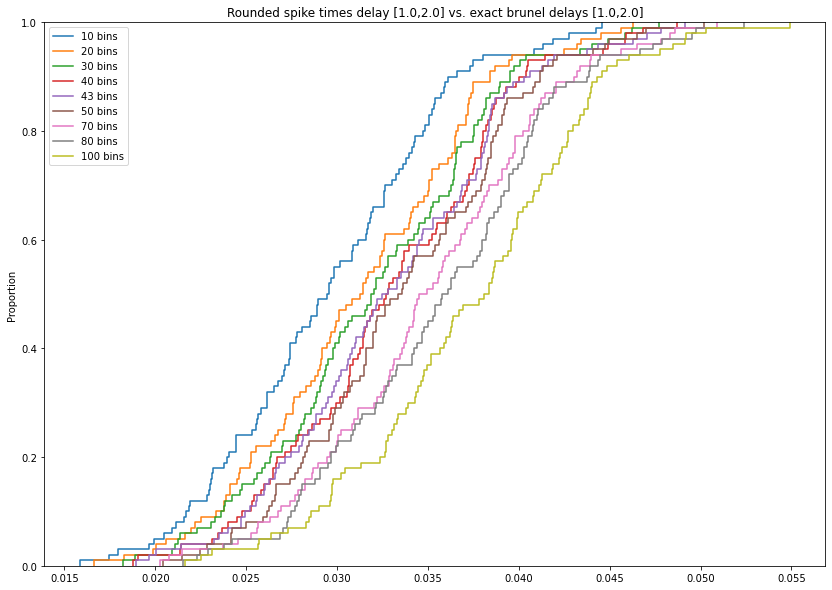

In [12]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(exc_c_10,ax=axs, label='10 bins')
sns.ecdfplot(exc_c_20,ax=axs, label='20 bins')
sns.ecdfplot(exc_c_30,ax=axs, label='30 bins')
sns.ecdfplot(exc_c_40,ax=axs, label='40 bins')
sns.ecdfplot(exc_c_43,ax=axs, label='43 bins')
sns.ecdfplot(exc_c_50,ax=axs, label='50 bins')
sns.ecdfplot(exc_c_70,ax=axs, label='70 bins')
sns.ecdfplot(exc_c_80,ax=axs, label='80 bins')
sns.ecdfplot(exc_c_100,ax=axs, label='100 bins')
plt.title('Rounded spike times delay [1.0,2.0] vs. exact brunel delays [1.0,2.0]')
plt.legend();

Higher divergences than the simulations from the same model, as expected. All of them under 0.055. Lets try for a model that is supposed to be more similar.

In [13]:
exc_c2_10 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=10)
exc_c2_20 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=20)
exc_c2_30 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=30)
exc_c2_40 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=40)
exc_c2_43 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=43)
exc_c2_50 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=50)
exc_c2_70 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=70)
exc_c2_80 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=80)
exc_c2_100 = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=100)

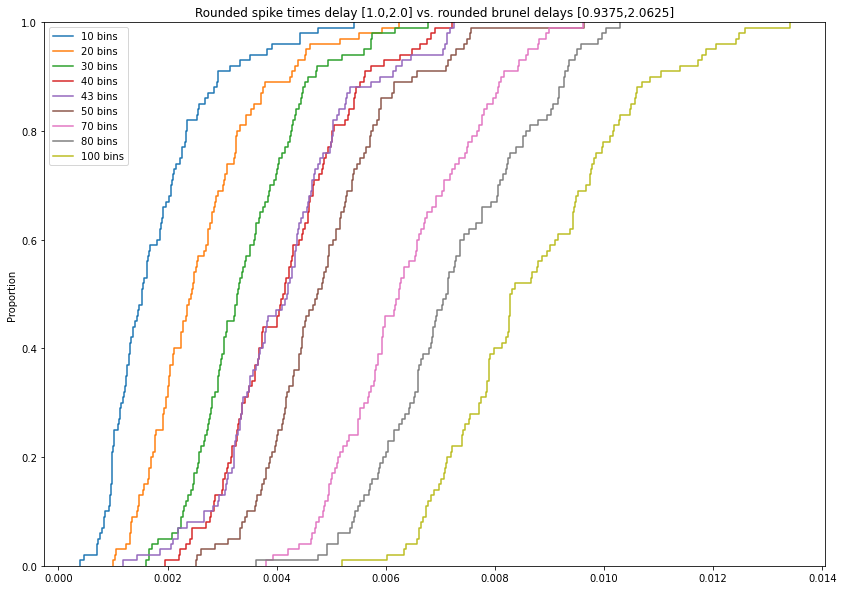

In [14]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(exc_c2_10,ax=axs, label='10 bins')
sns.ecdfplot(exc_c2_20,ax=axs, label='20 bins')
sns.ecdfplot(exc_c2_30,ax=axs, label='30 bins')
sns.ecdfplot(exc_c2_40,ax=axs, label='40 bins')
sns.ecdfplot(exc_c2_43,ax=axs, label='43 bins')
sns.ecdfplot(exc_c2_50,ax=axs, label='50 bins')
sns.ecdfplot(exc_c2_70,ax=axs, label='70 bins')
sns.ecdfplot(exc_c2_80,ax=axs, label='80 bins')
sns.ecdfplot(exc_c2_100,ax=axs, label='100 bins')
plt.title('Rounded spike times delay [1.0,2.0] vs. rounded brunel delays [0.9375,2.0625]')
plt.legend();

More similar to the case of simulations from the same model against each other. All divergences less than 0.014. Lets also do for the other two models, so that we have all to compare.

In [15]:
exc_c3_10 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=10)
exc_c3_20 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=20)
exc_c3_30 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=30)
exc_c3_40 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=40)
exc_c3_43 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=43)
exc_c3_50 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=50)
exc_c3_70 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=70)
exc_c3_80 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=80)
exc_c3_100 = kl_div_two_models(round_1_2_exc,exact_equal_exc,n_bins=100)

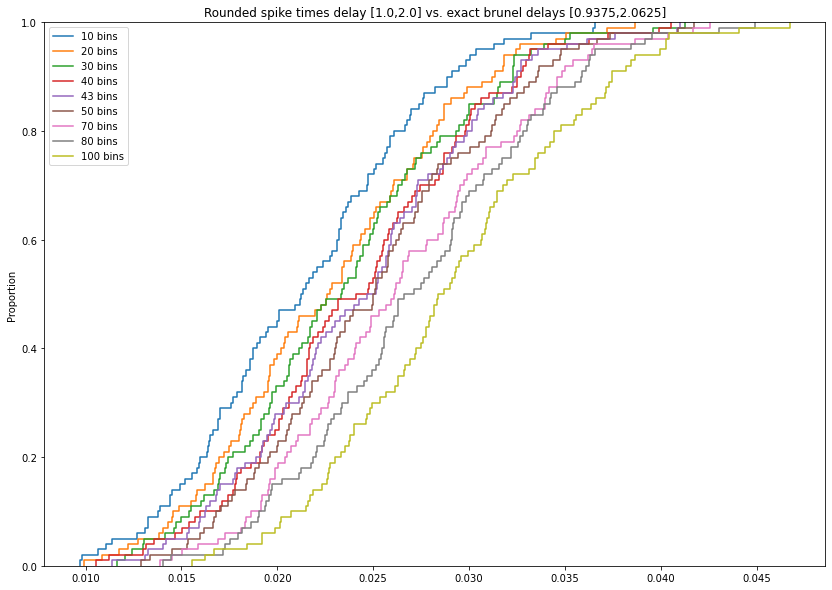

In [16]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(exc_c3_10,ax=axs, label='10 bins')
sns.ecdfplot(exc_c3_20,ax=axs, label='20 bins')
sns.ecdfplot(exc_c3_30,ax=axs, label='30 bins')
sns.ecdfplot(exc_c3_40,ax=axs, label='40 bins')
sns.ecdfplot(exc_c3_43,ax=axs, label='43 bins')
sns.ecdfplot(exc_c3_50,ax=axs, label='50 bins')
sns.ecdfplot(exc_c3_70,ax=axs, label='70 bins')
sns.ecdfplot(exc_c3_80,ax=axs, label='80 bins')
sns.ecdfplot(exc_c3_100,ax=axs, label='100 bins')
plt.title('Rounded spike times delay [1.0,2.0] vs. exact brunel delays [0.9375,2.0625]')
plt.legend();

Quite high divergences again. All of them around under 0.045. Makes sense as these models tend to be very different.

In [17]:
exc_c4_10 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=10)
exc_c4_20 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=20)
exc_c4_30 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=30)
exc_c4_40 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=40)
exc_c4_43 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=43)
exc_c4_50 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=50)
exc_c4_70 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=70)
exc_c4_80 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=80)
exc_c4_100 = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=100)

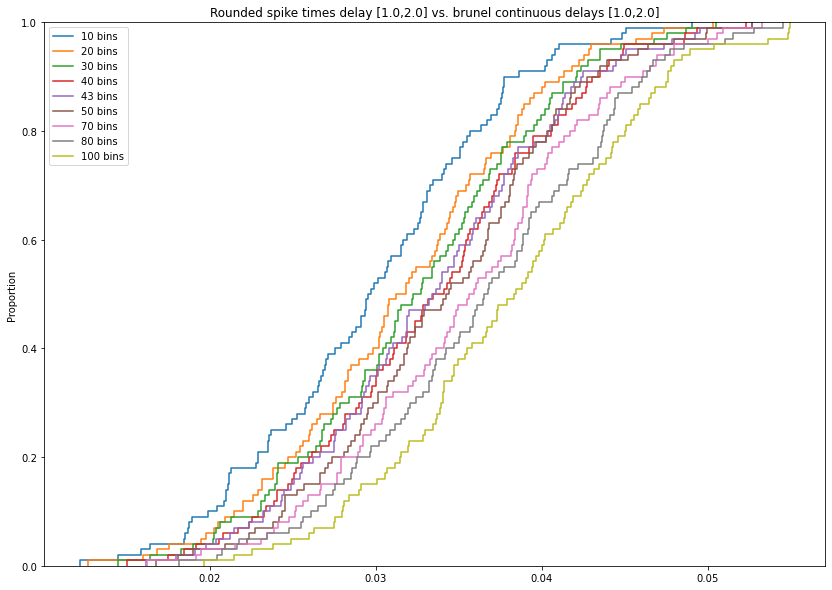

In [18]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(exc_c4_10,ax=axs, label='10 bins')
sns.ecdfplot(exc_c4_20,ax=axs, label='20 bins')
sns.ecdfplot(exc_c4_30,ax=axs, label='30 bins')
sns.ecdfplot(exc_c4_40,ax=axs, label='40 bins')
sns.ecdfplot(exc_c4_43,ax=axs, label='43 bins')
sns.ecdfplot(exc_c4_50,ax=axs, label='50 bins')
sns.ecdfplot(exc_c4_70,ax=axs, label='70 bins')
sns.ecdfplot(exc_c4_80,ax=axs, label='80 bins')
sns.ecdfplot(exc_c4_100,ax=axs, label='100 bins')
plt.title('Rounded spike times delay [1.0,2.0] vs. brunel continuous delays [1.0,2.0]')
plt.legend();

Quite high divergence. Make sense. Might be interesting to look at the brunel model with rounded spike times and delays [1.0,2.0] for higher and higher resolutions.

## Rounded brunel and delays [1.0, 2.0] with increasing resolution

Want to see how the brunel rounded 1 2 model moves compared to the exact 1 2 version. DOes it get closer as resolution increases.

In [19]:
cv_path = 'C:\\Users\\Nida\\Documents\\NMBU\\master\\spike_data\\CV_distributions'
res_1_8_exc = pd.read_csv(r'{}/resolution_1_8/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
res_1_8_inh = pd.read_csv(r'{}/resolution_1_8/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)
res_1_16_exc = pd.read_csv(r'{}/resolution_1_16/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
res_1_16_inh = pd.read_csv(r'{}/resolution_1_16/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)
res_1_32_exc = pd.read_csv(r'{}/resolution_1_32/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
res_1_32_inh = pd.read_csv(r'{}/resolution_1_32/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)
res_1_64_exc = pd.read_csv(r'{}/resolution_1_64/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
res_1_64_inh = pd.read_csv(r'{}/resolution_1_64/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)
res_1_128_exc = pd.read_csv(r'{}/resolution_1_128/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
res_1_128_inh = pd.read_csv(r'{}/resolution_1_128/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)
res_1_256_exc = pd.read_csv(r'{}/resolution_1_256/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
res_1_256_inh = pd.read_csv(r'{}/resolution_1_256/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)

### 10 bins

In [20]:
e1 = kl_divergences(res_1_8_exc,n_bins=10)
e2 = kl_divergences(res_1_16_exc,n_bins=10)
e3 = kl_divergences(res_1_32_exc,n_bins=10)
e4 = kl_divergences(res_1_64_exc,n_bins=10)
e5 = kl_divergences(res_1_128_exc,n_bins=10)
e6 = kl_divergences(res_1_256_exc,n_bins=10)

#kl_10 = kl_divergences_x(x,n_bins=10)
e7 = kl_divergences(exact_1_2_exc,n_bins=10)

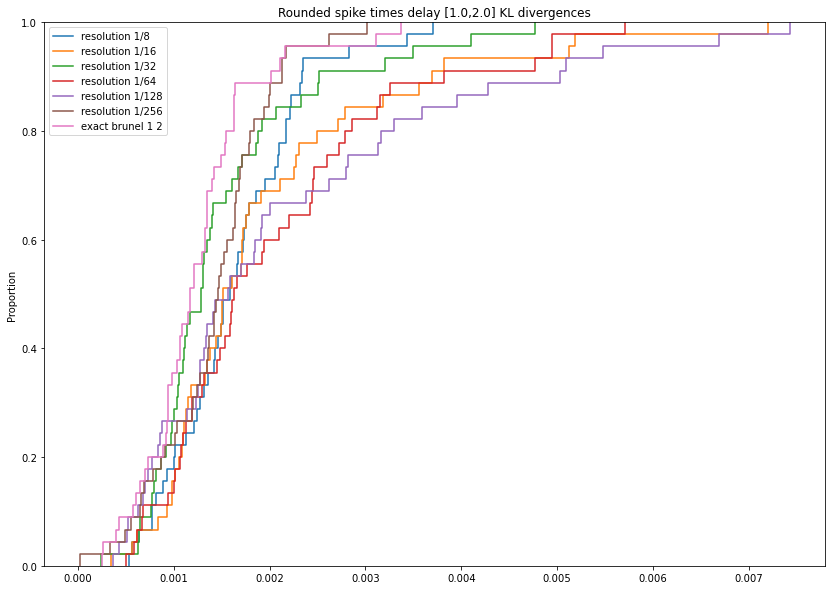

In [21]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(e1,ax=axs, label='resolution 1/8')
sns.ecdfplot(e2,ax=axs, label='resolution 1/16')
sns.ecdfplot(e3,ax=axs, label='resolution 1/32')
sns.ecdfplot(e4,ax=axs, label='resolution 1/64')
sns.ecdfplot(e5,ax=axs, label='resolution 1/128')
sns.ecdfplot(e6,ax=axs, label='resolution 1/256')
#sns.ecdfplot(kl_10,ax=axs, label='mock data')
sns.ecdfplot(e7,ax=axs, label='exact brunel 1 2')
plt.title('Rounded spike times delay [1.0,2.0] KL divergences')
plt.legend();

## 43 bins

In [22]:
e1 = kl_divergences(res_1_8_exc,n_bins=43)
e2 = kl_divergences(res_1_16_exc,n_bins=43)
e3 = kl_divergences(res_1_32_exc,n_bins=43)
e4 = kl_divergences(res_1_64_exc,n_bins=43)
e5 = kl_divergences(res_1_128_exc,n_bins=43)
e6 = kl_divergences(res_1_256_exc,n_bins=43)

#kl_10 = kl_divergences_x(x,n_bins=10)
e7 = kl_divergences(exact_1_2_exc,n_bins=43)

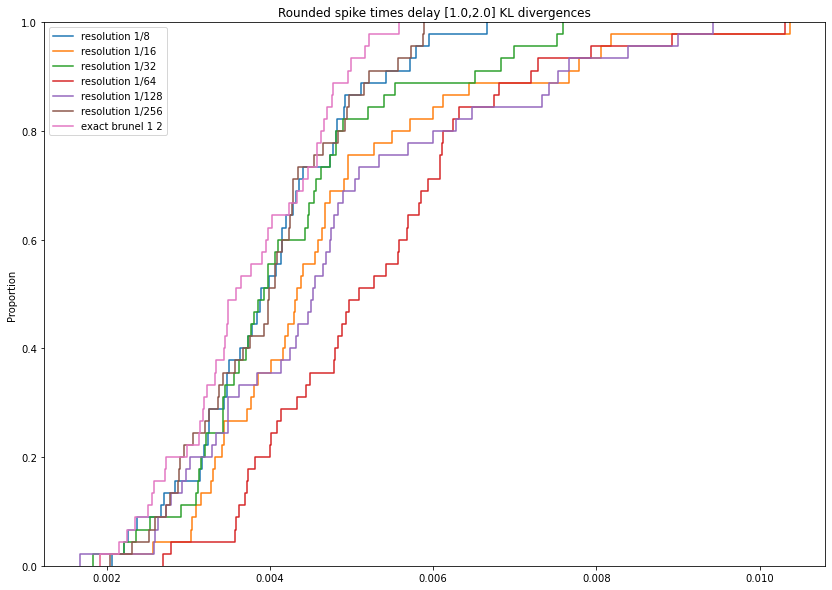

In [23]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(e1,ax=axs, label='resolution 1/8')
sns.ecdfplot(e2,ax=axs, label='resolution 1/16')
sns.ecdfplot(e3,ax=axs, label='resolution 1/32')
sns.ecdfplot(e4,ax=axs, label='resolution 1/64')
sns.ecdfplot(e5,ax=axs, label='resolution 1/128')
sns.ecdfplot(e6,ax=axs, label='resolution 1/256')
#sns.ecdfplot(kl_10,ax=axs, label='mock data')
sns.ecdfplot(e7,ax=axs, label='exact brunel 1 2')
plt.title('Rounded spike times delay [1.0,2.0] KL divergences')
plt.legend();



### 50 bins


In [24]:
e1 = kl_divergences(res_1_8_exc,n_bins=50)
e2 = kl_divergences(res_1_16_exc,n_bins=50)
e3 = kl_divergences(res_1_32_exc,n_bins=50)
e4 = kl_divergences(res_1_64_exc,n_bins=50)
e5 = kl_divergences(res_1_128_exc,n_bins=50)
e6 = kl_divergences(res_1_256_exc,n_bins=50)

#kl_10 = kl_divergences_x(x,n_bins=10)
e7 = kl_divergences(exact_1_2_exc,n_bins=50)

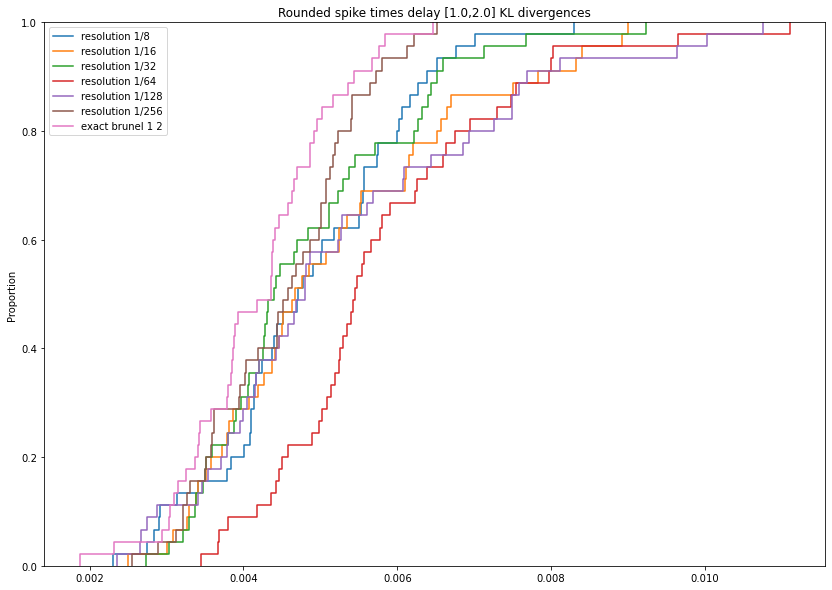

In [25]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(e1,ax=axs, label='resolution 1/8')
sns.ecdfplot(e2,ax=axs, label='resolution 1/16')
sns.ecdfplot(e3,ax=axs, label='resolution 1/32')
sns.ecdfplot(e4,ax=axs, label='resolution 1/64')
sns.ecdfplot(e5,ax=axs, label='resolution 1/128')
sns.ecdfplot(e6,ax=axs, label='resolution 1/256')
#sns.ecdfplot(kl_50,ax=axs, label='mock data')
sns.ecdfplot(e7,ax=axs, label='exact brunel 1 2')
plt.title('Rounded spike times delay [1.0,2.0] KL divergences')
plt.legend();



### 100 bins

In [26]:
e1 = kl_divergences(res_1_8_exc,n_bins=100)
e2 = kl_divergences(res_1_16_exc,n_bins=100)
e3 = kl_divergences(res_1_32_exc,n_bins=100)
e4 = kl_divergences(res_1_64_exc,n_bins=100)
e5 = kl_divergences(res_1_128_exc,n_bins=100)
e6 = kl_divergences(res_1_256_exc,n_bins=100)

#kl_10 = kl_divergences_x(x,n_bins=10)
e7 = kl_divergences(exact_1_2_exc,n_bins=100)

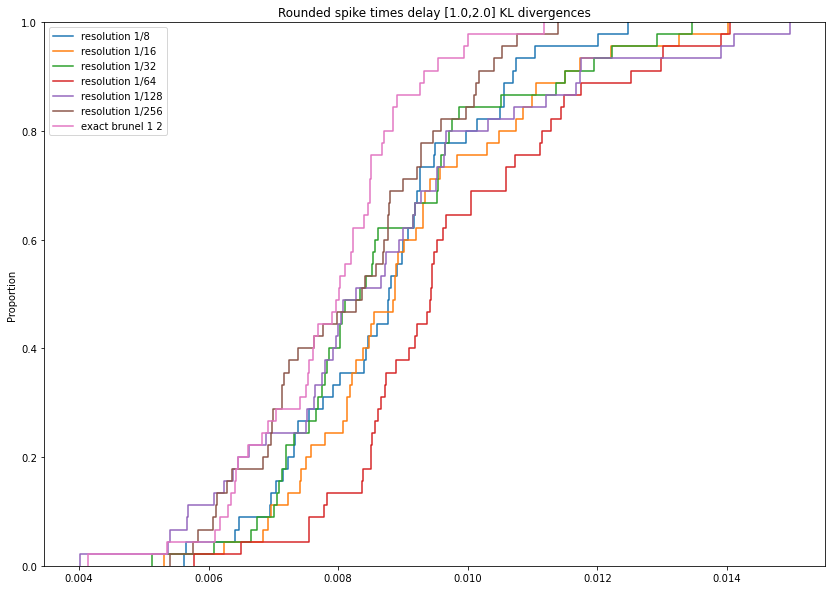

In [27]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(e1,ax=axs, label='resolution 1/8')
sns.ecdfplot(e2,ax=axs, label='resolution 1/16')
sns.ecdfplot(e3,ax=axs, label='resolution 1/32')
sns.ecdfplot(e4,ax=axs, label='resolution 1/64')
sns.ecdfplot(e5,ax=axs, label='resolution 1/128')
sns.ecdfplot(e6,ax=axs, label='resolution 1/256')
#sns.ecdfplot(kl_100,ax=axs, label='mock data')
sns.ecdfplot(e7,ax=axs, label='exact brunel 1 2')

plt.title('Rounded spike times delay [1.0,2.0] KL divergences')
plt.legend();



## 1000 bins

In [28]:
e1 = kl_divergences(res_1_8_exc,n_bins=1000)
e2 = kl_divergences(res_1_16_exc,n_bins=1000)
e3 = kl_divergences(res_1_32_exc,n_bins=1000)
e4 = kl_divergences(res_1_64_exc,n_bins=1000)
e5 = kl_divergences(res_1_128_exc,n_bins=1000)
e6 = kl_divergences(res_1_256_exc,n_bins=1000)

#kl_10 = kl_divergences_x(x,n_bins=10)
e7 = kl_divergences(exact_1_2_exc,n_bins=1000)

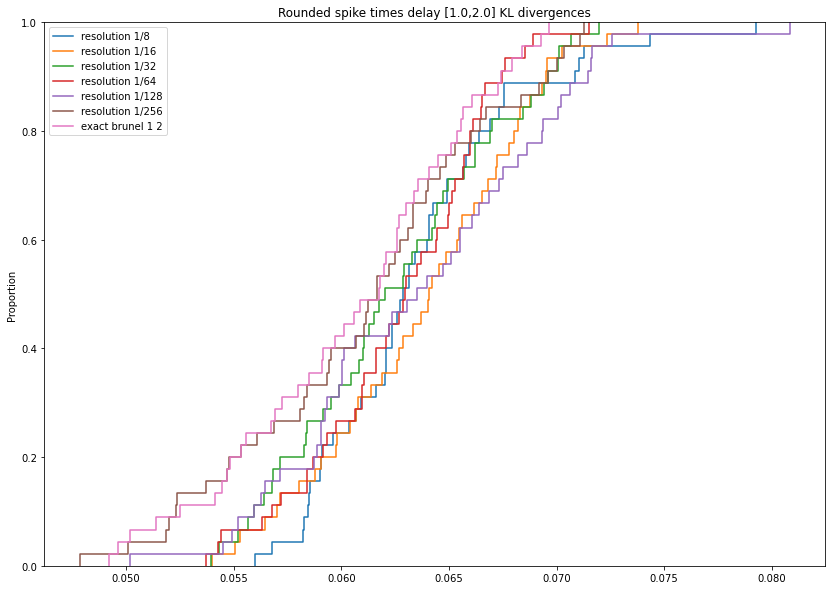

In [29]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(e1,ax=axs, label='resolution 1/8')
sns.ecdfplot(e2,ax=axs, label='resolution 1/16')
sns.ecdfplot(e3,ax=axs, label='resolution 1/32')
sns.ecdfplot(e4,ax=axs, label='resolution 1/64')
sns.ecdfplot(e5,ax=axs, label='resolution 1/128')
sns.ecdfplot(e6,ax=axs, label='resolution 1/256')
#sns.ecdfplot(kl_1000,ax=axs, label='mock data')
sns.ecdfplot(e7,ax=axs, label='exact brunel 1 2')

plt.title('Rounded spike times delay [1.0,2.0] KL divergences')
plt.legend();

Let us try to calculate the KL divergence for rounded spike times vs. exact spike times and delays [1.0,2.0] for increasing resolutions.

In [30]:
e1 = kl_div_two_models(res_1_8_exc,exact_1_2_exc,n_bins=43)
e2 = kl_div_two_models(res_1_16_exc,exact_1_2_exc,n_bins=43)
e3 = kl_div_two_models(res_1_32_exc,exact_1_2_exc,n_bins=43)
e4 = kl_div_two_models(res_1_64_exc,exact_1_2_exc,n_bins=43)
e5 = kl_div_two_models(res_1_128_exc,exact_1_2_exc,n_bins=43)
e6 = kl_div_two_models(res_1_256_exc,exact_1_2_exc,n_bins=43)

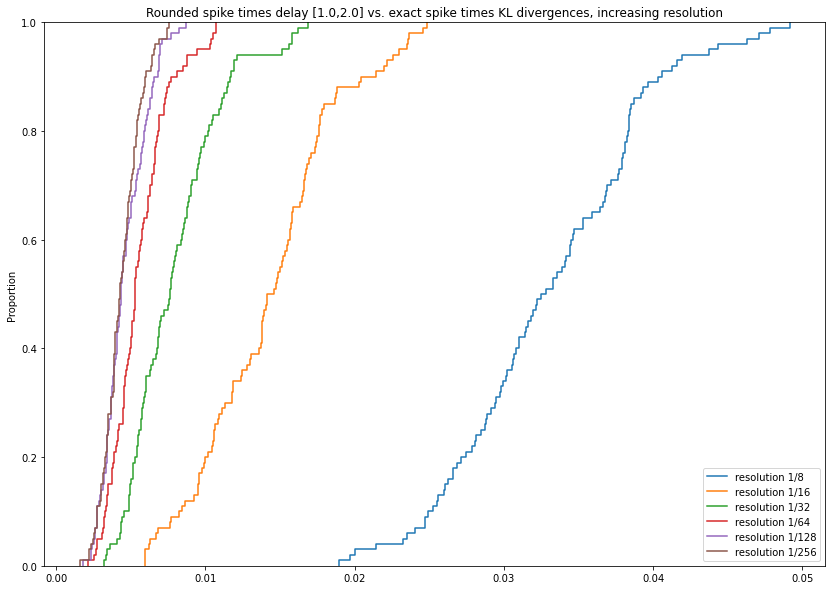

In [31]:
# excitatory spikes first, for different number of bins
_, axs = plt.subplots(1)
sns.ecdfplot(e1,ax=axs, label='resolution 1/8')
sns.ecdfplot(e2,ax=axs, label='resolution 1/16')
sns.ecdfplot(e3,ax=axs, label='resolution 1/32')
sns.ecdfplot(e4,ax=axs, label='resolution 1/64')
sns.ecdfplot(e5,ax=axs, label='resolution 1/128')
sns.ecdfplot(e6,ax=axs, label='resolution 1/256')


plt.title('Rounded spike times delay [1.0,2.0] vs. exact spike times KL divergences, increasing resolution')
plt.legend();

The divergence for simulations from the exact vs the rounded spike times brunel model gets smaller as resolution increases. See that for resolution 1/8 the divergence is up to 0.05. But for resolution 1/256 the divergence is under 0.01.

Lets try to calculate divergences for all pairs of simulations from the same model.

## 10 bins KL divergence for each model
THis uses the standard 10 bins. This should be performed for increasing number of bins.

In [44]:
divs_exc = kl_divergences(round_1_2_exc)
divs_inh = kl_divergences(round_1_2_inh)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.0037054357186489064  minimum divergence:  0.0005392714495221113
maximum divergence:  0.009390332115868169  minimum divergence:  0.0009705507512533674


In [45]:
divs_exc = kl_divergences(exact_1_2_exc)
divs_inh = kl_divergences(exact_1_2_inh)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.0033757699783035417  minimum divergence:  0.0002555636754937178
maximum divergence:  0.008609551419304612  minimum divergence:  0.0005839100016498291


In [46]:
divs_exc = kl_divergences(round_equal_exc)
divs_inh = kl_divergences(round_equal_inh)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.005842344060901759  minimum divergence:  0.0005787032209417723
maximum divergence:  0.01096743742516209  minimum divergence:  0.0014623843634200054


In [47]:
divs_exc = kl_divergences(exact_equal_exc)
divs_inh = kl_divergences(exact_equal_inh)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.0034933748406456447  minimum divergence:  0.0003178515138336309
maximum divergence:  0.008243086123336641  minimum divergence:  0.0012376919270871006


In [48]:
divs_exc = kl_divergences(continuous_exc)
divs_inh = kl_divergences(continuous_inh)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.0041793819171697  minimum divergence:  0.0002859176366130705
maximum divergence:  0.01042777661212175  minimum divergence:  0.00019819516174178356


## 50 bins KL divergence for each model
This uses 50 bins. 

In [49]:
divs_exc = kl_divergences(round_1_2_exc,n_bins=50)
divs_inh = kl_divergences(round_1_2_inh,n_bins=50)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.008292836878756529  minimum divergence:  0.0022983759846647296
maximum divergence:  0.02774361073683557  minimum divergence:  0.010720071909098402


In [50]:
divs_exc = kl_divergences(exact_1_2_exc,n_bins=50)
divs_inh = kl_divergences(exact_1_2_inh,n_bins=50)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.006459023147748245  minimum divergence:  0.0018708099619278093
maximum divergence:  0.026786633562604932  minimum divergence:  0.009004902462090516


In [51]:
divs_exc = kl_divergences(round_equal_exc,n_bins=50)
divs_inh = kl_divergences(round_equal_inh,n_bins=50)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.009530296611414316  minimum divergence:  0.0028461471704096367
maximum divergence:  0.024146286728484283  minimum divergence:  0.005571064929835026


In [52]:
divs_exc = kl_divergences(exact_equal_exc,n_bins=50)
divs_inh = kl_divergences(exact_equal_inh,n_bins=50)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.007468467704745487  minimum divergence:  0.002026567192578305
maximum divergence:  0.026095922108520294  minimum divergence:  0.00843136666141182


In [53]:
divs_exc = kl_divergences(continuous_exc,n_bins=50)
divs_inh = kl_divergences(continuous_inh,n_bins=50)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.00876662588325609  minimum divergence:  0.0035218127773725483
maximum divergence:  0.02927015508309662  minimum divergence:  0.009406207776070532


## 100 bins KL divergence for each model
This uses 100 bins. 

In [104]:
divs_exc = kl_divergences(round_1_2_exc,n_bins=100)
divs_inh = kl_divergences(round_1_2_inh,n_bins=100)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.01247525587242598  minimum divergence:  0.0056196043254403685
maximum divergence:  0.044258318381456434  minimum divergence:  0.02040165376690353


In [105]:
divs_exc = kl_divergences(exact_1_2_exc,n_bins=100)
divs_inh = kl_divergences(exact_1_2_inh,n_bins=100)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.011180025649939116  minimum divergence:  0.004140773453507171
maximum divergence:  0.0493001294048924  minimum divergence:  0.020245248886802496


In [106]:
divs_exc = kl_divergences(round_equal_exc,n_bins=100)
divs_inh = kl_divergences(round_equal_inh,n_bins=100)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.013056832048250526  minimum divergence:  0.006077362410076574
maximum divergence:  0.04221578990540639  minimum divergence:  0.020581355818156757


In [57]:
divs_exc = kl_divergences(exact_equal_exc,n_bins=100)
divs_inh = kl_divergences(exact_equal_inh,n_bins=100)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.010845554514346585  minimum divergence:  0.0063270233344032084
maximum divergence:  0.04436916340870438  minimum divergence:  0.018228433788004986


In [58]:
divs_exc = kl_divergences(continuous_exc,n_bins=100)
divs_inh = kl_divergences(continuous_inh,n_bins=100)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.013548797187084259  minimum divergence:  0.006190949348539982
maximum divergence:  0.04051983508943649  minimum divergence:  0.017603574465022625


## 1000 bins KL divergence for each model
This uses 1000 bins. 

In [59]:
divs_exc = kl_divergences(round_1_2_exc,n_bins=1000)
divs_inh = kl_divergences(round_1_2_inh,n_bins=1000)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.07927654544714993  minimum divergence:  0.05599965287197012
maximum divergence:  0.2285688537607162  minimum divergence:  0.1514714855613035


In [60]:
divs_exc = kl_divergences(exact_1_2_exc,n_bins=1000)
divs_inh = kl_divergences(exact_1_2_inh,n_bins=1000)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.06962797744018627  minimum divergence:  0.049225299384895976
maximum divergence:  0.22211936640272933  minimum divergence:  0.15588583020351948


In [61]:
divs_exc = kl_divergences(round_equal_exc,n_bins=1000)
divs_inh = kl_divergences(round_equal_inh,n_bins=1000)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.07217776243534141  minimum divergence:  0.05476593992266038
maximum divergence:  0.21918479085924658  minimum divergence:  0.13722777112058587


In [62]:
divs_exc = kl_divergences(exact_equal_exc,n_bins=1000)
divs_inh = kl_divergences(exact_equal_inh,n_bins=1000)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.07310945778405634  minimum divergence:  0.053228763443586694
maximum divergence:  0.23631425799863226  minimum divergence:  0.16150485022661332


In [63]:
divs_exc = kl_divergences(continuous_exc,n_bins=1000)
divs_inh = kl_divergences(continuous_inh,n_bins=1000)
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.0775131732771282  minimum divergence:  0.05383578158173013
maximum divergence:  0.24339767970358325  minimum divergence:  0.1414203116675262


## Test models against eachother. 
Lets do it for 100 bins.

In [107]:
divs_exc = kl_div_two_models(round_1_2_exc,exact_1_2_exc)
divs_inh = kl_div_two_models(round_1_2_inh, exact_1_2_inh)

In [108]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.0445936510823815  minimum divergence:  0.015837590165627368
inhibitory. maximum divergence:  0.05625041580991918  minimum divergence:  0.00981379682876083


rounded 1 2 vs rounded equal.

In [109]:
divs_exc = kl_div_two_models(round_1_2_exc,round_equal_exc)
divs_inh = kl_div_two_models(round_1_2_inh, round_equal_inh)

In [110]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.005422198576236489  minimum divergence:  0.00039069366512981343
inhibitory. maximum divergence:  0.012778793419847676  minimum divergence:  0.00014128805815635283


rounded 1 2 vs continuous.

In [111]:
divs_exc = kl_div_two_models(round_1_2_exc,continuous_exc)
divs_inh = kl_div_two_models(round_1_2_inh, continuous_inh)

In [112]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.04905116584387102  minimum divergence:  0.012157828239834781
inhibitory. maximum divergence:  0.054727038275735364  minimum divergence:  0.009141051229016166


exact 1 2 vs. rounded equal.

In [113]:
divs_exc = kl_div_two_models(exact_1_2_exc,round_equal_exc)
divs_inh = kl_div_two_models(exact_1_2_inh, round_equal_inh)

In [114]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.04939798831694646  minimum divergence:  0.013456904777797403
inhibitory. maximum divergence:  0.05601912021030572  minimum divergence:  0.011636078121724337


exact 1 2 vs. exact equal.

In [115]:
divs_exc = kl_div_two_models(exact_1_2_exc,exact_equal_exc)
divs_inh = kl_div_two_models(exact_1_2_exc, exact_equal_exc)

In [116]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.005967765456675341  minimum divergence:  0.000245494600454612
inhibitory. maximum divergence:  0.005967765456675341  minimum divergence:  0.000245494600454612


exact 1 2 vs. continuous.

In [117]:
divs_exc = kl_div_two_models(exact_1_2_exc,continuous_exc)
divs_inh = kl_div_two_models(exact_1_2_inh, continuous_inh)

In [118]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.0042642135677748395  minimum divergence:  0.00012918979811094716
inhibitory. maximum divergence:  0.010595904599591383  minimum divergence:  0.001337395374599133


rounded equal vs. exact equal.

In [119]:
divs_exc = kl_div_two_models(round_equal_exc,exact_equal_exc)
divs_inh = kl_div_two_models(round_equal_inh, exact_equal_inh)

In [120]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.03588563727288472  minimum divergence:  0.007532292402863113
inhibitory. maximum divergence:  0.0463879976805233  minimum divergence:  0.004754210145138039


rounded equal vs. continuous.

In [121]:
divs_exc = kl_div_two_models(round_equal_exc,continuous_exc)
divs_inh = kl_div_two_models(round_equal_inh, continuous_inh)

In [122]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.04859746393401006  minimum divergence:  0.010845042528068229
inhibitory. maximum divergence:  0.059070851188201344  minimum divergence:  0.00946065410865358


exact equal vs. continouous.

In [123]:
divs_exc = kl_div_two_models(exact_equal_exc,continuous_exc)
divs_inh = kl_div_two_models(exact_equal_inh, continuous_inh)

In [124]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.006651950326366306  minimum divergence:  0.00044190786810752685
inhibitory. maximum divergence:  0.01299732510405978  minimum divergence:  0.00023717208455783796


## Test models against eachother. 
Lets do it for 43 bins.

In [33]:
divs_exc = kl_div_two_models(round_1_2_exc,exact_1_2_exc,n_bins=43)
divs_inh = kl_div_two_models(round_1_2_inh, exact_1_2_inh,n_bins=43)

In [34]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.04915718443986216  minimum divergence:  0.018949196823179304
inhibitory. maximum divergence:  0.06860233837370205  minimum divergence:  0.019070534845813725


rounded 1 2 vs rounded equal.

In [35]:
divs_exc = kl_div_two_models(round_1_2_exc,round_equal_exc,n_bins=43)
divs_inh = kl_div_two_models(round_1_2_inh, round_equal_inh,n_bins=43)

In [36]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.0072420876951727635  minimum divergence:  0.0011781701580157555
inhibitory. maximum divergence:  0.02336817906876471  minimum divergence:  0.005555965513950169


rounded 1 2 vs continuous.

In [37]:
divs_exc = kl_div_two_models(round_1_2_exc,continuous_exc,n_bins=43)
divs_inh = kl_div_two_models(round_1_2_inh, continuous_inh,n_bins=43)

In [38]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.05269931638959623  minimum divergence:  0.01613958072338707
inhibitory. maximum divergence:  0.06796177237939396  minimum divergence:  0.017693514851953265


exact 1 2 vs. rounded equal.

In [39]:
divs_exc = kl_div_two_models(exact_1_2_exc,round_equal_exc,n_bins=43)
divs_inh = kl_div_two_models(exact_1_2_inh, round_equal_inh,n_bins=43)

In [40]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.051147353714484575  minimum divergence:  0.015384916856522726
inhibitory. maximum divergence:  0.06854445876353754  minimum divergence:  0.02231855754861959


exact 1 2 vs. exact equal.

In [41]:
divs_exc = kl_div_two_models(exact_1_2_exc,exact_equal_exc,n_bins=43)
divs_inh = kl_div_two_models(exact_1_2_exc, exact_equal_exc,n_bins=43)

In [42]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.009361293082707263  minimum divergence:  0.0014864034865814855
inhibitory. maximum divergence:  0.009361293082707263  minimum divergence:  0.0014864034865814855


exact 1 2 vs. continuous.

In [43]:
divs_exc = kl_div_two_models(exact_1_2_exc,continuous_exc,n_bins=43)
divs_inh = kl_div_two_models(exact_1_2_inh, continuous_inh,n_bins=43)

In [44]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.006290396865128939  minimum divergence:  0.0022036201032497563
inhibitory. maximum divergence:  0.023833448874234723  minimum divergence:  0.005856281288637463


rounded equal vs. exact equal.

In [45]:
divs_exc = kl_div_two_models(round_equal_exc,exact_equal_exc,n_bins=43)
divs_inh = kl_div_two_models(round_equal_inh, exact_equal_inh,n_bins=43)

In [46]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.04194876667793353  minimum divergence:  0.01011714547164479
inhibitory. maximum divergence:  0.06384348867815255  minimum divergence:  0.013376424835485403


rounded equal vs. continuous.

In [47]:
divs_exc = kl_div_two_models(round_equal_exc,continuous_exc,n_bins=43)
divs_inh = kl_div_two_models(round_equal_inh, continuous_inh,n_bins=43)

In [48]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.05406935259457634  minimum divergence:  0.015158535911915912
inhibitory. maximum divergence:  0.0723749674151264  minimum divergence:  0.018802688514744627


exact equal vs. continouous.

In [51]:
divs_exc = kl_div_two_models(exact_equal_exc,continuous_exc,n_bins=43)
divs_inh = kl_div_two_models(exact_equal_inh, continuous_inh,n_bins=43)

In [52]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.00965766259401652  minimum divergence:  0.002269905874928345
inhibitory. maximum divergence:  0.02768044378104157  minimum divergence:  0.008852368171015014
